# Station Clustering (Summer 2018)
This notebook uses K-means clustering with PCA to group stations into 3 different clusters. 

The station features are the total hourly 'Activity' and 'Flux' where: 

    Activity = num_pickups + num_dropoffs

    Flux = num_pickups - num_dropoffs

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('./data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df = pd.read_pickle('./data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df = pd.read_pickle('./data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')
###

In [3]:
subs_df[subs_df['start station latitude']>41]

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender


In [4]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [5]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [6]:
#Need to filter out stations in stations_info_df that do not appear in weekend_subs_trips
station_drops = []
WE_unique = np.unique(np.concatenate((weekend_subs_trips_df['start station id'].unique(),weekend_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WE_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WE_unique)


[3036, 3240, 3485, 3683, 3704, 493, 3040, 3267, 3275, 3214, 3199, 3270, 3183, 3103, 3487, 3198, 3213, 3203, 3192, 3268]


True

In [7]:
weekend_subs_trips_df.head()

,tripduration,starttime,stoptime,start station id,end station id,bikeid,usertype,birth year,gender,start_day,stop_day,pickup_hour,dropoff_hour,age,Trip_Type,start_end_station
155,449,2018-06-02 00:38:55.625,2018-06-02 00:46:25.314,72,529,32944,Subscriber,1988,1,5,5,0,0,30,Weekend,"(72, 529)"
158,743,2018-06-02 02:00:16.492,2018-06-02 02:12:39.978,72,500,14980,Subscriber,1999,1,5,5,2,2,19,Weekend,"(72, 500)"
159,357,2018-06-02 07:10:46.644,2018-06-02 07:16:44.311,72,457,18840,Subscriber,1981,1,5,5,7,7,37,Weekend,"(72, 457)"
160,521,2018-06-02 07:32:45.649,2018-06-02 07:41:27.025,72,533,31040,Subscriber,1981,1,5,5,7,7,37,Weekend,"(72, 533)"
161,382,2018-06-02 07:39:52.955,2018-06-02 07:46:15.558,72,3173,19164,Subscriber,1987,1,5,5,7,7,31,Weekend,"(72, 3173)"


In [8]:
WE_puhour_groupby = weekend_subs_trips_df.groupby(['start station id', 'pickup_hour'])
WE_puhour_df = WE_puhour_groupby.count()['tripduration'].rename('NumPickups').reset_index(1).pivot(columns = 'pickup_hour').fillna(0)

WE_dohour_groupby = weekend_subs_trips_df.groupby(['end station id', 'dropoff_hour'])
WE_dohour_df = WE_dohour_groupby.count()['tripduration'].rename('NumDropoffs').reset_index(1).pivot(columns = 'dropoff_hour').fillna(0)


In [9]:
WE_counts_df = pd.concat([WE_puhour_df,WE_dohour_df],axis=1).fillna(0)
WE_counts_df['total_pickups'] = WE_counts_df['NumPickups'].sum(axis=1)
WE_counts_df['total_dropoffs'] = WE_counts_df['NumDropoffs'].sum(axis=1)

In [10]:
for num in range(24):
    WE_counts_df['Activity',num] =  WE_counts_df['NumPickups',num] + WE_counts_df['NumDropoffs',num]
    WE_counts_df['Flux',num] =  WE_counts_df['NumPickups',num] - WE_counts_df['NumDropoffs',num]
WE_counts_df['total_counts'] = WE_counts_df['Activity'].sum(axis=1)

# Normalize by total activity for station -- maybe just do this right before clustering step?
for num in range(24):
    WE_counts_df['norm_Activity',num] =  WE_counts_df['Activity',num]/WE_counts_df['total_counts']
    WE_counts_df['norm_Flux',num] =  WE_counts_df['Flux',num]/WE_counts_df['total_counts']


In [11]:
WE_counts_df.sort_values('total_counts',ascending=False).head()

NumPickups                                                   \
pickup_hour         0     1     2     3     4     5     6     7      8    
497               68.0  40.0  20.0  11.0   4.0   5.0  20.0  53.0  122.0   
435               48.0  29.0  25.0  22.0   8.0   5.0  11.0  37.0  196.0   
285              127.0  69.0  42.0  22.0  18.0  10.0  24.0  62.0  121.0   
426               73.0  26.0  12.0   1.0   6.0  12.0  29.0  96.0  170.0   
368              153.0  91.0  63.0  53.0  23.0  11.0  37.0  73.0  137.0   

                      ...    norm_Activity norm_Flux norm_Activity norm_Flux  \
pickup_hour     9     ...               19        19            20        20   
497          207.0    ...         0.051054  0.005788      0.032873  0.006159   
435          287.0    ...         0.061874  0.003241      0.044163  0.002864   
285          216.0    ...         0.071849  0.003996      0.049985  0.003694   
426          252.0    ...         0.069138 -0.002190      0.047865  0.000313   
368          239.0    ...         0.076480 -0.000243      0.056448 -0.006650   

            norm_Activity norm_Flux norm_Activity norm_Flux norm_Activity  \
pickup_hour            21        21            22        22            23   
497              0.024414  0.003785      0.015954  0.005120      0.009424   
435              0.033537  0.001432      0.015299  0.000980      0.008742   
285              0.044632  0.003468      0.029704  0.004674      0.018999   
426              0.035429  0.004771      0.023932  0.000469      0.012514   
368              0.046634  0.000406      0.036496  0.003731      0.024493   

            norm_Flux  
pickup_hour        23  
497          0.001855  
435         -0.000301  
285          0.001960  
426         -0.000939  
368          0.000162  

[5 rows x 147 columns]

In [14]:
#Imported/modified from UMICH coursera course, a simple scatter plot function

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


def plot_labelled_scatter(X, y, class_labels, pca_vars = (0,1)):
    num_labels = len(class_labels)

    x_min, x_max = X[:, pca_vars[0]].min() - 1, X[:, pca_vars[0]].max() + 1
    y_min, y_max = X[:, pca_vars[1]].min() - 1, X[:, pca_vars[1]].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, pca_vars[0]], X[:, pca_vars[1]], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()
    
def plot_3d_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    z_min, z_max = X[:, 2].min() - 1, X[:, 2].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    fig = plt.figure()
    ax = Axes3D(fig)
    #ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1],X[:, 2], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)
    #plt.zlim(z_min, z_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    

In [15]:
import tilemapbase
tilemapbase.start_logging()

In [16]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [17]:
t = tilemapbase.tiles.Carto_Light

In [18]:
hour_mark_loc = (-74.02,40.77)
x_cen, y_cen = tilemapbase.project(*hour_mark_loc)

stations = [tilemapbase.project(x,y) for x,y in zip(stations_info_df['lon'], stations_info_df['lat'])]
x, y = zip(*stations)

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def color_st(x):
    sns.set_color_codes()
    if x == 0:
        return 'b'
    elif x == 1:
        return 'orange'
    elif x == 2:
        return 'g'
    elif x == 3:
        return 'r'

# Clustering with norm_Activity and norm_Flux

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WE_counts_df[['norm_Activity','norm_Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(782, 48) (782, 2)


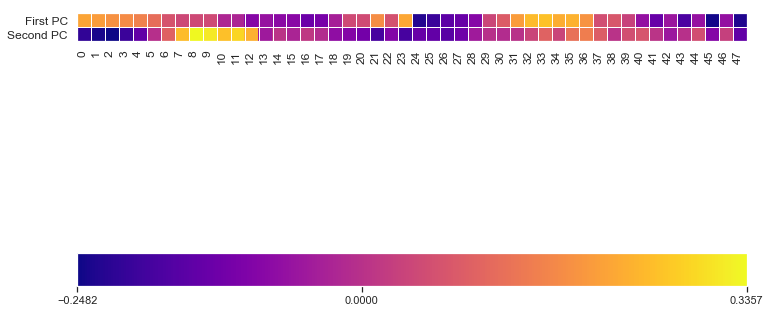

In [23]:
fig = plt.figure(figsize=(12, 6))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

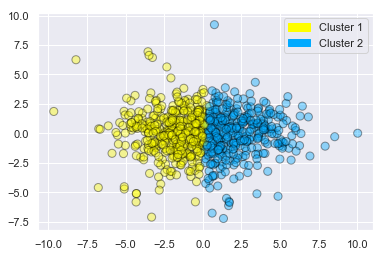

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_pca)

WE_counts_df['KNN_label'] = kmeans.labels_

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2'])

Plotting norm_Flux

In [25]:
test_df=WE_counts_df[['norm_Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [26]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

In [27]:
test_melt_df.head()

,hour,station,count,KNN_label
0,0,72,0.003505,0
1,1,72,0.002410,0
2,2,72,0.005038,0
3,3,72,0.000657,0
4,4,72,0.000000,0


C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


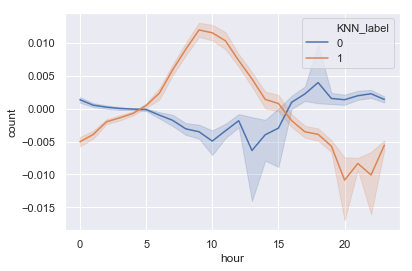

In [28]:
## Using norm_Flux 
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors=2), data=test_melt_df)

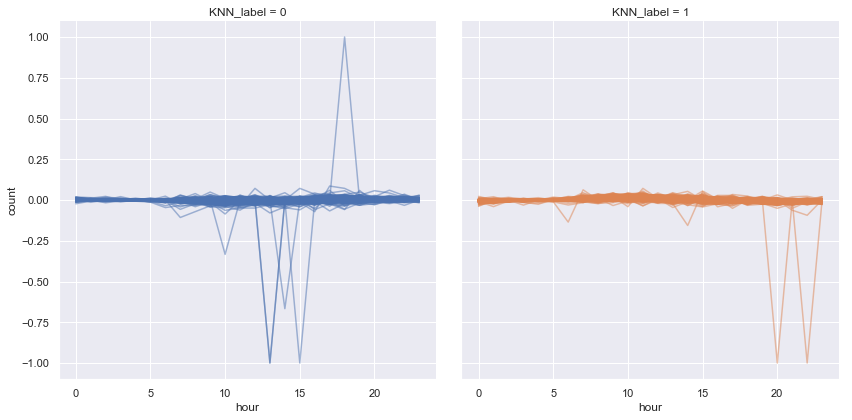

In [29]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1,2], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

Plotting Activity

In [30]:
test_df=WE_counts_df[['norm_Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [31]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

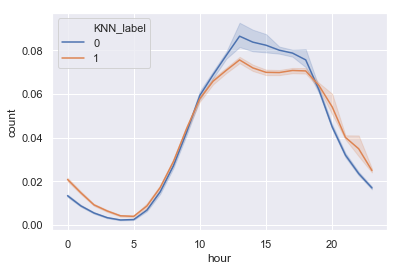

In [32]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', palette = sns.color_palette(n_colors=2), data=test_melt_df)


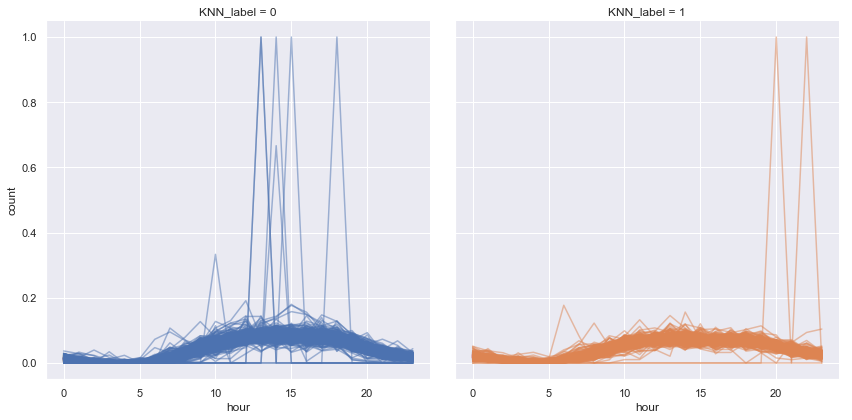

In [33]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

In [34]:
stations_info_df['KNN_label'] = WE_counts_df['KNN_label']
stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

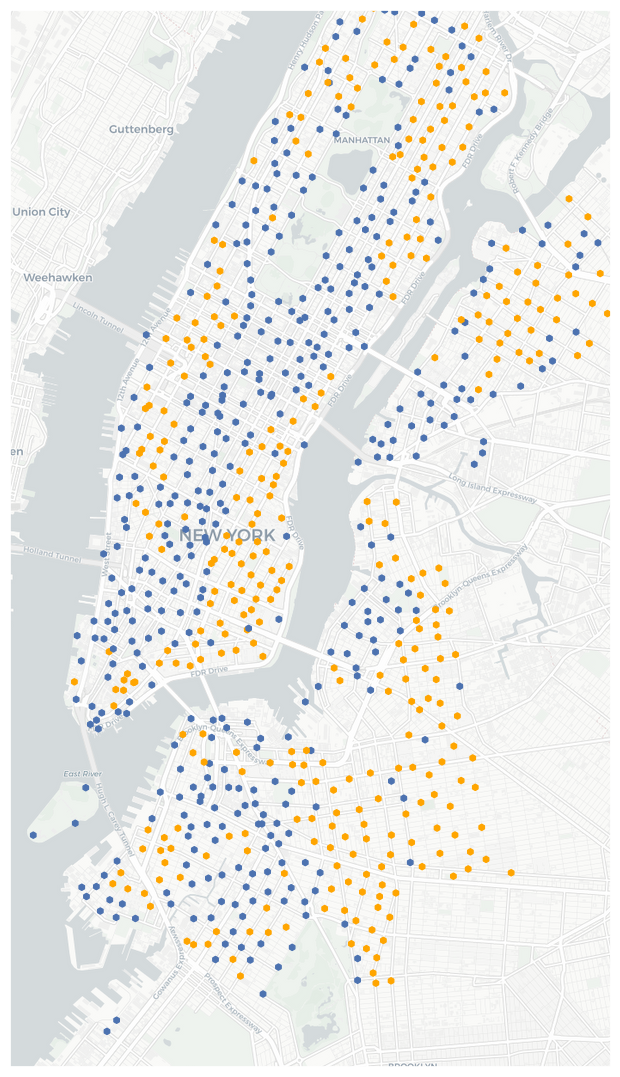

In [35]:
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)

## Now using Activity and Flux

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

X = WE_counts_df[['Activity','Flux']].values
#y_fruits = fruits[['fruit_label']] - 1

X_normalized = StandardScaler().fit(X).transform(X)
#X_normalized = MinMaxScaler().fit(X).transform(X)

pca = PCA(n_components = 2).fit(X_normalized)
X_pca = pca.transform(X_normalized)

print(X.shape, X_pca.shape)

(782, 48) (782, 2)


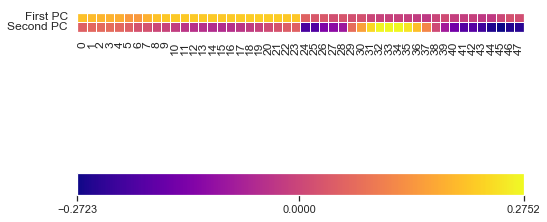

In [37]:
fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
#feature_names = list(cancer.feature_names)

plt.gca().set_xticks(np.arange(-.5, 48)) #len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(range(48), rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

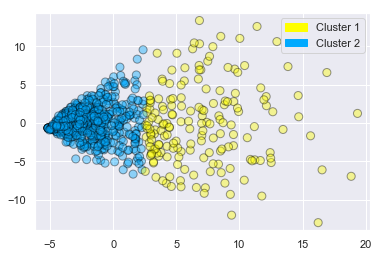

In [38]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

kmeans = KMeans(n_clusters = 2)
kmeans.fit(X_pca)

plot_labelled_scatter(X_pca, kmeans.labels_, 
                      ['Cluster 1', 'Cluster 2'])
#plot_labelled_scatter(X_pca, kmeans.labels_, 
#                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (0,2))
#plot_labelled_scatter(X_pca, kmeans.labels_, 
#                      ['Cluster 1', 'Cluster 2', 'Cluster 3'],pca_vars = (1,2))

In [39]:
WE_counts_df['KNN_label'] = kmeans.labels_

Plotting Flux

In [40]:
test_df=WE_counts_df[['Flux','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [41]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

C:\Users\pgsze\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


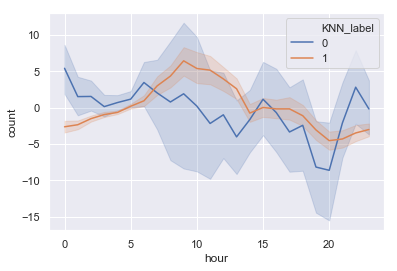

In [42]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


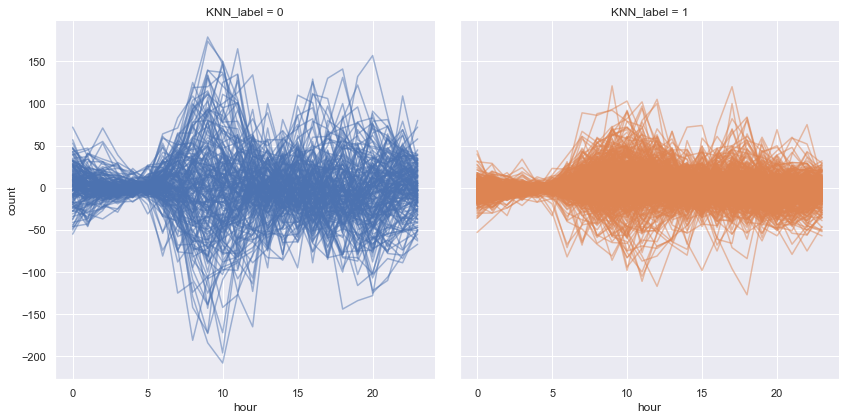

In [43]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

Plotting Activity

In [44]:
test_df=WE_counts_df[['Activity','KNN_label']].transpose().reset_index().rename({'pickup_hour':'hour'},axis=1).drop('level_0',axis=1)
test_melt_df = test_df.iloc[0:24].melt('hour', var_name='station', value_name='count')
test_melt_df['KNN_label']=test_melt_df['station'].map(lambda x: test_df.iloc[24][x])

In [45]:
test_melt_df['KNN_label']=test_melt_df['KNN_label'].astype(int)

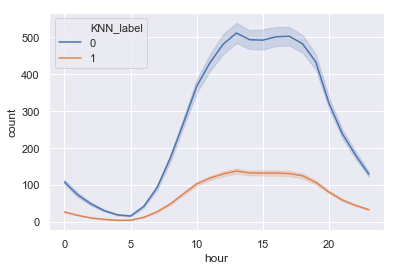

In [46]:
%matplotlib inline
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

sns.set(style="darkgrid")

ax = sns.lineplot(x="hour", y="count", hue = 'KNN_label', data=test_melt_df)
#ax = sns.catplot(x="hour", y="count", hue = 'station', data=test_df21)


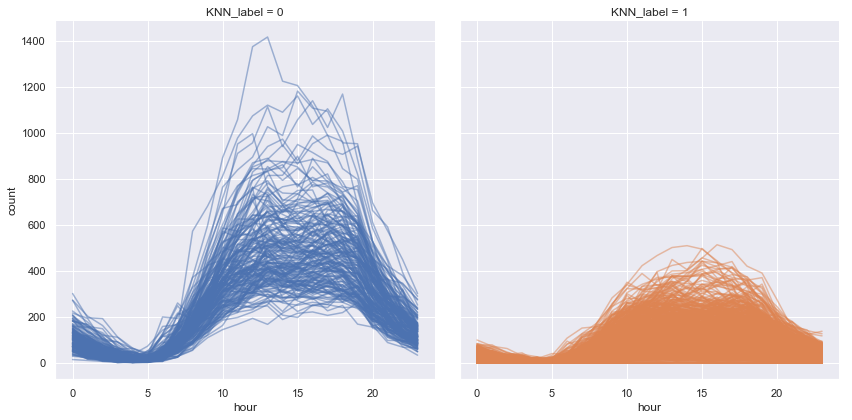

In [47]:
#All station data
sns.set(font_scale=1)

g = sns.FacetGrid(test_melt_df,col='KNN_label',hue='KNN_label', hue_order=[0,1], height=6)
g = g.map_dataframe(sns.lineplot, 'hour','count', estimator = None, units='station',alpha=.5)

In [48]:
stations_info_df['KNN_label'] = WE_counts_df['KNN_label']
stations_info_df['color'] = stations_info_df['KNN_label'].map(lambda x: color_st(x))

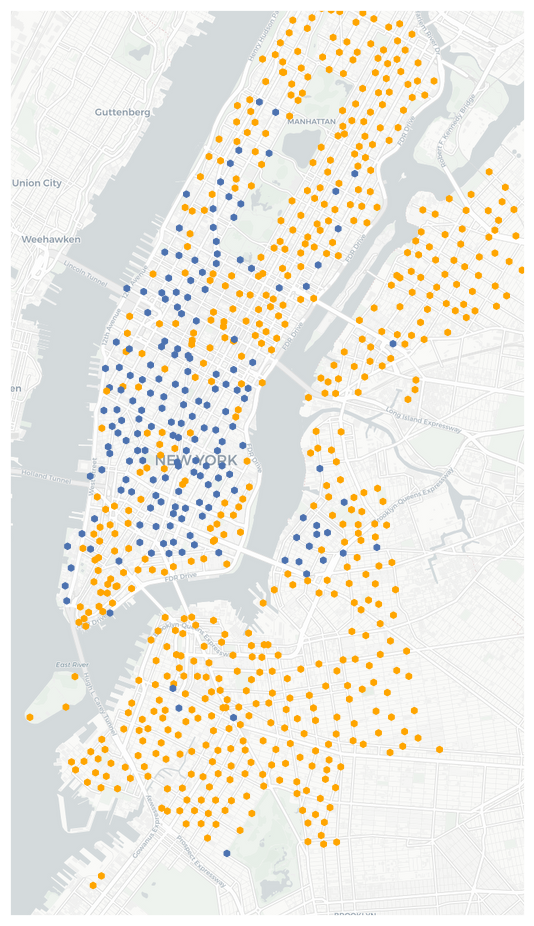

In [49]:
fig, ax = plt.subplots(figsize=(12,12), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

ax.scatter(x,y, marker = 'h', color = stations_info_df['color'], alpha = 1, s = 20)#, animated=True);
   
#plt.annotate('hour = {}'.format(num), [x_cen,y_cen]);
#
#ax.set_title('Winter 2018, weekday dropoffs, hour = {}'.format(num))

#cax, _ = mpl.colorbar.make_axes(ax)
#cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, ticks=[0, .5, 1])#, norm=normalize)
#cbar.ax.set_yticklabels(['0',  '{:.1f} per day'.format(WE_max_dropoff_cap/2/num_WE) , '> ' +  '{:.1f} per day'.format(WE_max_dropoff_cap/num_WE)])# vertically oriented colorbar

#plt.savefig('./Images/Winter_2018/Winter_2018_WE_drops_{}.png'.format(str(num)));
#plt.close()